In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy import interp
import pandas.core.algorithms as algos 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time

/PythonApp/anaconda1/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### data from clipboard

In [11]:
col = pd.read_clipboard(header=None)

In [12]:
droplist1 = pd.read_clipboard(header=None)[0].values

In [44]:
df1 = pd.read_csv('/data2/GMC/rgpm_allattrib_dev_cln.csv',header= None)#,converters = {'.':np.nan})#,nrows=5000)
df1.columns = col[0].values
df1=df1.set_index(df1.Seqnum)
df1.shape

/PythonApp/anaconda1/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7,17,18,39,40,41,52,61,62,63,65,67,68,69,70,87,89,90,91,101,103,104,105,106,123,125,126,127,137,139,140,141,142,159,161,162,163,173,175,176,177,178,195,197,198,199,209,211,212,213,214,231,233,234,235,245,247,248,249,250,267,269,270,271,282,284,285,286,287,304,306,307,308,319,321,322,323,324,341,343,344,345,356,358,359,360,361,378,380,381,382,393,395,396,397,398,415,417,418,419,430,432,433,434,435,452,454,455,456,467,469,470,471,472,489,491,492,493,515,516,1509,1510,1511) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(615098, 3543)

In [45]:

df1 = df1.drop(droplist1,1)
print df1.shape

(615098, 3513)


In [46]:
df1 = df1.replace('.',np.nan)
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [47]:
df1.head()

,SBFE_FLAG,SEGMENT_PM2016,BUSINESS_DATE,BOOK_DATE,MATURITY_DATE,EXPIRATION_DATE,CHARGE_OFF_DT,COMMITED_DATE,LATE_FEES_MTD_AMT,BUSINESS_ESTABLISH_DATE,...,AVG1y_DTRI72,chg_DTRI77_1,Achg_DTRI77_12,MN_PC1_DTRI77,AVG1y_DTRI79,chg_DTRI84_9,MIN1y_DTRI88,MAX1y_IE53,MAX_NG2_IE79,Seqnum
Seqnum,,,,,,,,,,,,,,,,,,,,,
1,1,1,09/30/2014,11/02/1995,11/09/2014,NaN,NaN,NaN,NaN,NaN,...,15.916667,-0.522821,-23490,-0.509047,19.583333,-0.523252,-225,0,-7,1
2,1,5,09/30/2014,05/30/2012,08/24/2013,08/24/2013,NaN,05/24/2012,NaN,NaN,...,8.166667,-0.070411,-1246,-0.067218,12.500000,-0.980406,0,0,-4,2
3,1,7,09/30/2014,10/29/2012,09/01/2017,NaN,NaN,NaN,NaN,NaN,...,32.083333,0.000000,107882,0.627901,63.333333,0.040932,30557,1,-39,3
4,1,8,09/30/2014,12/28/2001,12/05/2014,12/05/2014,NaN,12/21/2001,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,1,8,09/30/2014,11/21/2012,11/19/2017,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


#### Seperate numeric and non-numeric variables

In [48]:
def var_classfication(data):
    var_object = data.dtypes[data.dtypes==object].index
    var_date = [x for x in var_object if type(x)=='str' and x[-3:]=='dte' ]
    var_nonnum = [x for x in var_object if x not in var_date]
    var_num = data.dtypes[data.dtypes!=object].index
    return var_date,var_nonnum,var_num

var_date,var_nonnum,var_num = var_classfication(df1)

In [49]:
print var_nonnum

['BUSINESS_DATE', 'BOOK_DATE', 'MATURITY_DATE', 'EXPIRATION_DATE', 'CHARGE_OFF_DT', 'COMMITED_DATE', 'BUSINESS_ESTABLISH_DATE', 'DD_DIRECT_DEPOSIT_IND', 'CD_BILLPAY_IND', 'DD_BILLPAY_IND', 'IRA_BILLPAY_IND', 'SV_BILLPAY_IND', 'CHRG_OFF_AMT_ind', 'account_open_ind', 'BUSINESSDATE', 'BASECAT', 'TIXIE', 'IMPORT', 'LOC_IND', 'HQBR_IND']


#### Category variables with 10+ levels

In [52]:
for i,j in enumerate(df1[var_nonnum]):
        ct = df1[j].nunique()
        if ct >10:
            print j,ct#i

BOOK_DATE 3246
MATURITY_DATE 5703
EXPIRATION_DATE 3543
CHARGE_OFF_DT 20
COMMITED_DATE 5219
BUSINESS_ESTABLISH_DATE 934


In [53]:
for i,j in enumerate(df1[var_nonnum]):
        ct = df1[j].nunique()
        if ct <=10:
            print j,ct#i

BUSINESS_DATE 9
DD_DIRECT_DEPOSIT_IND 3
CD_BILLPAY_IND 3
DD_BILLPAY_IND 3
IRA_BILLPAY_IND 3
SV_BILLPAY_IND 3
CHRG_OFF_AMT_ind 2
account_open_ind 2
BUSINESSDATE 9
BASECAT 3
TIXIE 2
IMPORT 4
LOC_IND 3
HQBR_IND 3


In [62]:
def sic2d(row_):
    if row_=='    ' or row_!=row_ or row_ == '' or row_ == ' ':
        return 11
    else:
        row = int(row_)/100
        #if row.isin(43, 90,91,92,93,94,95,96,97,98):
        if row >  0 and row<=9:
            return 1
        elif row<=14:
            return 2
        elif row<-17:
            return 3
        elif row<=39:
            return 4
        elif row<=49:
            return 5
        elif row<=51:
            return 6
        elif row<=59:
            return 7
        elif row<=67:
            return 8
        elif row<=89:
            return 9
        elif row<=97:
            return 10
        else:
            return 11
df1['sic2d'] = df1['SIC4'].map(sic2d)
def age(df):
    df.YRSTART = df.YRSTART.replace(to_replace=[' ','  ','   ','    '], value=2016)
    df.YRSTART = df.YRSTART.astype(float)
    df['start_age'] = 2016 - df['YRSTART'] 
    df.loc[df.start_age>200,:].start_age = 200
    return df
age(df1)

#### Pull all category variables with < 10 levels

In [56]:
var_nonnum.remove('BUSINESSDATE')
var_nonnum.remove('BUSINESS_DATE')

In [57]:
dummylist1 = [j for i,j in enumerate(df1[var_nonnum]) if df1[j].nunique()<=10]

#### create dummy variable

In [58]:

dummy_matrix=pd.DataFrame()
nan_map = lambda x: 0 if x!= x else x
for j in dummylist1:
    dummy = pd.get_dummies(df1[j].map(nan_map),prefix=j)
    dummy_matrix = pd.concat([dummy_matrix,dummy],1)
dummy_matrix.head()

,DD_DIRECT_DEPOSIT_IND_,DD_DIRECT_DEPOSIT_IND_N,DD_DIRECT_DEPOSIT_IND_Y,CD_BILLPAY_IND_,CD_BILLPAY_IND_N,CD_BILLPAY_IND_Y,DD_BILLPAY_IND_,DD_BILLPAY_IND_N,DD_BILLPAY_IND_Y,IRA_BILLPAY_IND_,...,IMPORT_,IMPORT_B,IMPORT_C,IMPORT_D,LOC_IND_,LOC_IND_H,LOC_IND_S,HQBR_IND_,HQBR_IND_R,HQBR_IND_S
Seqnum,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,1,0
2,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,1,0
3,1,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0
5,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0


In [59]:
df2=pd.concat([df1[var_num],dummy_matrix],1)
df2.shape


(615098, 3527)

#### impute missing 

In [60]:
df3 = df2.fillna(0)

In [61]:
df1.NEW_BAD.value_counts()

0    601034
1     14064
Name: NEW_BAD, dtype: int64

In [102]:
droplist2 = [i for i in df3.columns.values if i[4:15]=='PDUE_BUCKET']
df3 = df3.drop(droplist2,1)

In [103]:
y= df3['NEW_BAD']
X = df3.drop(['NEW_BAD','SEGMENT_PM2016'],1)
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.3, random_state=3243)

2

#### alternatively, impute to median

In [ ]:
from sklearn.preprocessing import Imputer, MinMaxScaler
imp = Imputer(missing_values='NaN', strategy='median')
imp.fit(Xtrain)
Xtrain=imp.transform(Xtrain)

#### Run a quick random forest model to see if top predictors makes sense

In [105]:
forest = RandomForestClassifier(     n_estimators=100, 
                                    #class_weight='balanced_subsample',
                                    max_depth = 80,
                                    min_samples_leaf=500,
                                    #max_features=100,
                                    n_jobs=-1)

model = forest

import time
start = time.time()    
model.fit(X_train,y_train)
end = time.time()
print(end - start)

136.623786926


In [106]:
proba= model.predict_proba(X_train)
print roc_auc_score(y_train,proba[:,1])
proba= model.predict_proba(X_test)
print  roc_auc_score(y_test,proba[:,1])

0.921454524363
0.902421111868


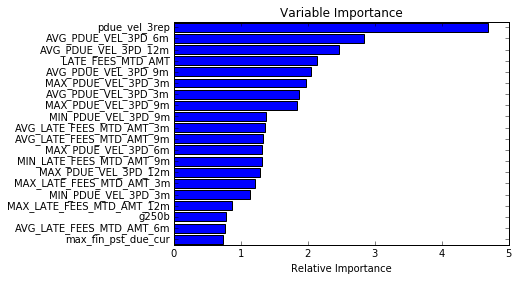

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
cols = X_train.columns
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance )#/ feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]
top_sorted_idx = sorted_idx[:20]
pos = np.arange(top_sorted_idx.shape[0]) + .5
#fig = plt.figure() 
plt.barh(pos, feature_importance[top_sorted_idx][::-1], align='center')
plt.yticks(pos, cols[top_sorted_idx][::-1])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
#plt.savefig("var_importance1.png")
plt.show()

In [108]:
top_sorted_idx = sorted_idx[:50]
t1 = cols[top_sorted_idx].values
t2 = feature_importance[top_sorted_idx]

In [122]:
sum([i > 0.0 for i in feature_importance])

2599

In [113]:
np.argsort(feature_importance)[::-1]

array([  33,  235,  451, ..., 1355, 1356, 1714])

In [119]:
feature_importance[1355]>1.0

False

In [64]:
df2.to_csv('/data2/GMC/rgpm_allattrib_dev_cln2.csv',index=False)

In [66]:
import pickle
pickle.dump(df2,'/data2/GMC/rgpm_allattrib_dev_cln2.pkl')

AttributeError: 'str' object has no attribute 'write'

In [5]:
meta = pd.read_table('rgpm_allattrib_oot_meta.txt')

In [6]:

col = meta.Variable.values
meta['pd_type'] = meta['Type'].map({'Num':np.float,'Char':str})
meta.loc[meta['Format'].astype(str).map(lambda x:x[:4])=='MMDD','pd_type'] = str
converter1 = meta.pd_type.to_dict()
meta.pd_type = str
converter2 = meta.pd_type.to_dict()

In [7]:
###holdout_sample
start = time.time()    
dfh = pd.read_csv('/data2/GMC/rgpm_allattrib_oot_cln.csv',na_values=['.'],header= None,converters =converter2)
dfh.columns = col
dfh=dfh.set_index(dfh.Seqnum)
dfh.shape
end = time.time()
print(end - start)

207.732226133


In [53]:
#keeplist= col[0][~col[0].isin(droplist2)].values

In [8]:
start = time.time()  
dfh = dfh.replace('.',np.nan)
dfh = dfh.apply(lambda x: pd.to_numeric(x, errors='ignore'))
end = time.time()
print(end - start)
#df_h.fillna('0',inplace=True)
#df_h = df_h.replace(' ','0')

120.094368935


In [9]:
df1_short = pd.read_csv('/data2/GMC/rgpm_allattrib_dev_cln2.csv',nrows = 10)

In [10]:
def var_classfication(data):
    var_object = data.dtypes[data.dtypes==object].index
    var_date = [x for x in var_object if type(x)=='str' and x[-3:]=='dte' ]
    var_nonnum = [x for x in var_object if x not in var_date]
    var_num = data.dtypes[data.dtypes!=object].index
    return var_date,var_nonnum,var_num

var_date,var_nonnum,var_num = var_classfication(dfh)

In [11]:
dummylist2 = [j for i,j in enumerate(dfh[var_nonnum]) if dfh[j].nunique()<=10]
dummylist2

['BUSINESS_DATE',
 'TCE_SIZE',
 'ROLLUP_ID_TYPE',
 'PRODUCT_TYPE_LEVEL1',
 'PRODUCT_TYPE_LEVEL2',
 'INT_ACCURAL_BASIS_CODE',
 'INT_ACCURAL_BASIS_NAME',
 'STOP_ACCRUAL_IND',
 'PRODUCT_CORE_CLASS',
 'PRODUCT_SUPER_CLASS',
 'DD_DIRECT_DEPOSIT_IND',
 'CD_BILLPAY_IND',
 'DD_BILLPAY_IND',
 'IRA_BILLPAY_IND',
 'SV_BILLPAY_IND',
 'CHRG_OFF_AMT_ind',
 'account_open_ind',
 'Actual_Archive_Date',
 'BUSINESSDATE',
 'NIXIE_B',
 'NIXIE_C',
 'Home_Based_Business_Ind',
 'source',
 'BASECAT',
 'HISTORY',
 'COND_IND',
 'FINANCE',
 'STMT_TYP',
 'EAA_TYP',
 'TIXIE',
 'COMPTYPE',
 'IMPORT',
 'LOC_IND',
 'HQBR_IND']

In [14]:
# create dummy variable
dummy_matrix=pd.DataFrame()
nan_map = lambda x: 0 if x!= x else x
for j in dummylist2:
    dummy = pd.get_dummies(dfh[j].map(nan_map),prefix=j)
    dummy_matrix = pd.concat([dummy_matrix,dummy],1)
dummy_matrix.head()

df_h2=pd.concat([dfh[var_num],dummy_matrix],1)
print df_h2.shape

(199115, 3621)


In [15]:
print set(df_h2.columns) - set(df1_short.columns)
print set(df1_short.columns) - set(df_h2.columns)

set(['STOP_ACCRUAL_IND_Y', 'BUSINESS_DATE_07/31/2015', 'ROLLUP_ID_TYPE_TIN', 'STOP_ACCRUAL_IND_N', 'TCE_SIZE_2MM-5MM', 'NIXIE_C_5', 'NIXIE_C_4', 'NIXIE_C_1', 'NIXIE_C_0', 'NIXIE_C_3', 'NIXIE_C_2', 'INT_ACCURAL_BASIS_CODE_1', 'INT_ACCURAL_BASIS_CODE_3', 'INT_ACCURAL_BASIS_CODE_5', 'INT_ACCURAL_BASIS_CODE_4', 'PRODUCT_TYPE_LEVEL2_LINE OF CREDIT - SECURED', 'INT_ACCURAL_BASIS_CODE_6', 'PRODUCT_TYPE_LEVEL1_TERM', 'PRODUCT_SUPER_CLASS_COMMERCIAL', 'INT_ACCURAL_BASIS_NAME_ACT/365', 'NIXIE_C_ ', 'INT_ACCURAL_BASIS_NAME_ACT/366', 'INT_ACCURAL_BASIS_CODE_ ', 'PRODUCT_SUPER_CLASS_COMMERCIAL LOANS & LEASES', 'BUSINESSDATE_0', 'BUSINESSDATE_07/31/2015', 'INT_ACCURAL_BASIS_CODE_N/A', 'INT_ACCURAL_BASIS_NAME_3', 'INT_ACCURAL_BASIS_NAME_1', 'source_Unmatched', 'PRODUCT_TYPE_LEVEL2_FLEXLINE - UNSECURED', 'INT_ACCURAL_BASIS_NAME_ ', 'INT_ACCURAL_BASIS_NAME_N/A', 'COMPTYPE_H', 'COMPTYPE_I', 'COMPTYPE_G', 'TCE_SIZE_>5MM', 'Actual_Archive_Date_ ', 'PRODUCT_TYPE_LEVEL1_LINE', 'AR_ID', 'Home_Based_Business_

#### Check if any difference in attribute list between train and validation dataset 

In [16]:
misscolumn = (set(df1_short.columns) - set(df_h2.columns)) 
for a in misscolumn:
             df_h2[a]=0
df_h2 = df_h2[df1_short.columns]



In [19]:
droplist2 = [i for i in df_h2.columns.values if i[4:15]=='PDUE_BUCKET']
df_h2 = df_h2.drop(droplist2,1)
df_h2.shape

(199115, 3515)

In [21]:
df_h2.to_csv('/data2/GMC/rgpm_allattrib_oot_cln2.csv',index=False)

###### Another validation dataset. Don't use

In [10]:
df_h = pd.read_csv('/data2/GMC/bfs_capital_ml_no_perf.csv',header= None,converters = {'.':0})

In [5]:
df2 = pd.read_csv('/data2/GMC/sbfe_ml_train.csv')

In [40]:
col = pd.read_clipboard(header=None)
df_h.columns = col[0].map(lambda x:x.upper()).values
df_h = df_h.set_index(df_h.LEADID)
df_h = df_h.replace('.',0)
df_h = df_h.apply(lambda x: pd.to_numeric(x, errors='ignore'))
df_h.fillna('0',inplace=True)
df_h = df_h.replace(' ','0')

def var_classfication(data):
    var_object = data.dtypes[data.dtypes==object].index
    var_date = [x for x in var_object if x[-3:]=='dte']
    var_nonnum = [x for x in var_object if x not in var_date]
    var_num = data.dtypes[data.dtypes!=object].index
    return var_date,var_nonnum,var_num

var_date,var_nonnum,var_num = var_classfication(df_h)

dummylist2 = [j for i,j in enumerate(df_h[var_nonnum]) if df_h[j].nunique()<=10]
dummy_matrix=pd.DataFrame()
nan_map = lambda x: 0 if x!= x else x
for j in dummylist2:
    dummy = pd.get_dummies(df_h[j].map(nan_map),prefix=j)
    dummy_matrix = pd.concat([dummy_matrix,dummy],1)
dummy_matrix.head()

df_h2=pd.concat([df_h[var_num],dummy_matrix],1)
print df_h2.shape
df2.columns = df2.columns.map(lambda x:x.upper())
print set(df_h2.columns) - set(df2.columns)
print set(df2.columns) - set(df_h2.columns)
misscolumn = set(df2.columns) - set(df_h2.columns)
for a in misscolumn:
             df_h2[a]=0
df_h2 = df_h2[df2.columns]
print df_h2.shape

(7336, 1317)
set(['INQCS', 'BNKRPTDT', 'SMSACODE', 'CONTROL', 'ACTUAL_ARCHIVE_DATE', 'INQREG', 'PHONE', 'EAADATE', 'BASEDATE', 'FBASEDAT', 'DATE_IND_0', 'DATE_IND_I', 'DATE_IND_D', 'LEADID', 'YRSTART', 'DATE_IND_T', 'DATE_OB', 'ZIP_CODE', 'STMTDATE', 'DATE_BD', 'HQ_DUNS', 'DUNS_NUMBER'])
set(['STMT_TYP_Y', 'STMT_TYP_X', 'EAA_TYP_H', 'BAD', 'STMT_TYP_I', 'STMT_TYP_H', 'BAD_CO'])
(7336, 1302)


In [43]:
df_h2.to_csv('/data2/GMC/sbfe_ml_valid2.csv')
